## Finite sample SFS calculation and plots

In [ ]:
from scipy.special import erfinv
from scipy.stats import gamma
from scipy.stats import nbinom
from scipy import special
import numpy as np
import sys
import math
sys.path.insert(1,'numerics_snakemake')
from plot_sfs import *
from matplotlib import pyplot as plt
from power_v2 import *
from plot_expseg import *

## Derivation of finite SFS

Assuming that the samples are taken independently from the population with replacement, the number of copies of the deleterious allele in a finite sample of size $n$ is the sum of $n$ Bernoulli trials with probability of success $P$:
$$\xi_k^{(n)}={n\choose k}P^k(1-P)^k$$

Alternatively, we can write:
$$\xi^{(n)}\sim\text{Binom}(n,P)$$

For large $n$ and small $P$, we can approximate this distribution as Poisson:
$$\xi^{(n)}\sim\text{Pois}(nP)$$

We have previously shown that $$P\sim\text{Gamma}(\alpha,\beta)$$

The expected value of the $k$-th entry in the SFS is then given by:
\begin{align}
\mathbb{E}\left[\text{Pr}\left(\xi_k^{(n)}\right)\right]&=\mathbb{E}\left[\frac{(nP)^ke^{-nP}}{k!}\right]\\
&=\frac{n^k}{k!}\int_0^\infty P^ke^{-nP}\frac{\beta^\alpha}{\Gamma(\alpha)}P^{\alpha-1}e^{-\beta P}dP\\
&=\frac{n^k\beta^\alpha}{k!\Gamma(\alpha)}\int_0^\infty P^{k+\alpha-1}e^{-(n+\beta)P}dP\\
&=\frac{n^k\beta^\alpha}{k!\Gamma(\alpha)}\int_0^\infty \left(\frac{z}{n+\beta}\right)^{(k+\alpha-1}e^{-z}\frac{1}{n+\beta}dz\\
&=\frac{n^k\beta^\alpha}{k!\Gamma(\alpha)}(n+\beta)^{-(k+\alpha)}\int_0^\infty z^{k+\alpha-1}e^{-z}dz\\
&=\frac{n^k\beta^\alpha\Gamma(k+\alpha)}{k!(n+\beta)^{k+\alpha}\Gamma(\alpha)}
\end{align}


### Plots

In [2]:
# load data
data = pd.read_csv("numerics_snakemake/spatial_integrals_dim2.csv")
data_pr = pd.read_csv("numerics_snakemake/cleaned_data_dim2_errorFalse.csv")
data_pr = data_pr.loc[data_pr['poly_type'] == '1_1']

sigma_vals = data['sigma'].tolist()
kappa_list = data['u2_GQ'].tolist()
res_vals = data_pr['residues']
pole_vals = data_pr['poles']

In [3]:
def finite_sfs_k(n,k,sigma,s,sigma_vals,pole_vals,res_vals,mu=1e-8,N=10000,D=1,d=2):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N,D,d)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,mu,N,D,d)
    num=(n**k)*(beta**alpha)*special.gamma(alpha+k)
    denom=math.factorial(k)*((n+beta)**(k+alpha))*special.gamma(alpha)
    return(num/denom)

In [4]:
nval=1e6
sg=0.1
sval=0.01
kmax=40

sg_vals = [0.1,10,100]
sfs_sg0 = [finite_sfs_k(nval,k,sg_vals[0],sval,sigma_vals,pole_vals,res_vals) for k in range(kmax)]
sfs_sg1 = [finite_sfs_k(nval,k,sg_vals[1],sval,sigma_vals,pole_vals,res_vals) for k in range(kmax)]
sfs_sg2 = [finite_sfs_k(nval,k,sg_vals[2],sval,sigma_vals,pole_vals,res_vals) for k in range(kmax)]


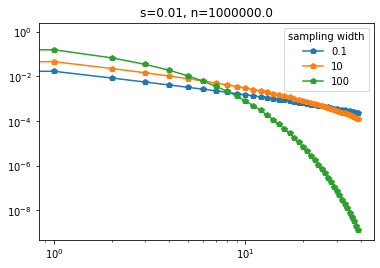

In [5]:
def exp_seg(sigma,s,sigma_vals,res_vals,pole_vals,n=1e6,Nval=10000,d=2):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N=Nval,d=d)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,N=Nval,d=d)
    print(alpha)
    exp_val = 1-((1+(n/beta))**(-1*alpha))
#     print(((1+(n/beta))**(-1*alpha)))
    return(exp_val)


fig,ax = plt.subplots()
ax.plot(range(kmax),sfs_sg0,label=str(sg_vals[0]),marker='p')
ax.plot(range(kmax),sfs_sg1,label=str(sg_vals[1]),marker='p')
ax.plot(range(kmax),sfs_sg2,label=str(sg_vals[2]),marker='p')
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(title="sampling width")
plt.title("s="+str(sval)+", n="+str(nval))
plt.savefig("finite_sfs.png")

### Conditioned allele frequency

In [7]:
sigma=0.1
s=0.01
N=10000
D=1
d=2
mu=1e-8
rate = rate_p(sigma,s,sigma_vals,pole_vals,N,D,d)
shape = shape_p(sigma,s,sigma_vals,res_vals,mu,N,D,d)
seg_prob = 1-((1+(nval/rate))**(-1*shape))

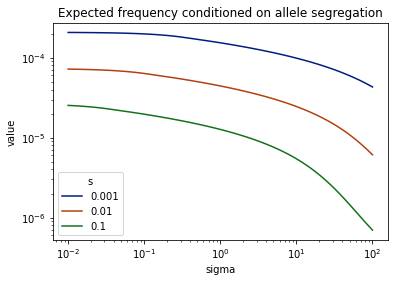

In [11]:
def exp_seg_prob(sigma,s,sigma_vals,res_vals,pole_vals,n=1e6,Nval=10000):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N=Nval)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,N=Nval)
    exp_val = 1-((1+(n/beta))**(-1*alpha))
    return(exp_val)

sigma_list = np.logspace(-2, 2, 100)
colors = sns.color_palette("dark", 3)
fig,ax = plt.subplots()
n_ax = 1e7
s_vals = [0.001,0.01,0.1]
ax.plot(sigma_list,
                  [(mu/s_vals[0])/exp_seg_prob(sg, s_vals[0], sigma_vals, res_vals, pole_vals, n=n_ax) for sg in sigma_list],
                  color=colors[0])
ax.plot(sigma_list,
                  [(mu/s_vals[1])/exp_seg_prob(sg, s_vals[1], sigma_vals, res_vals, pole_vals, n=n_ax) for sg in sigma_list],
                  color=colors[1])
ax.plot(sigma_list,
                  [(mu/s_vals[2])/exp_seg_prob(sg, s_vals[2], sigma_vals, res_vals, pole_vals, n=n_ax) for sg in sigma_list],
                  color=colors[2])
ax.legend(labels=[str(sv) for sv in s_vals],title="s")
ax.set_title("Expected frequency conditioned on allele segregation")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("sigma")
ax.set_ylabel("value")
plt.show()